* Rent the Runway is an online company who specializes in renting dresses for occasions ranging from casual dates, to formal    occasions.

* We are examining clothing reviews  from Rent the Runway data. 

* Our objective is to assist the buyers of Rent the Runway in making the best possible accurate clothing acquisitions by predicting the rating an item may receive.


In [1]:
#Suppress warnings...
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import warnings
import string
import re
import nltk
import spacy
import json
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
token = nltk.tokenize.WhitespaceTokenizer()
lemma = nltk.stem.WordNetLemmatizer()
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.decomposition import TruncatedSVD
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

In [3]:
df = pd.read_csv('renttherunway_final_data.csv')
df.shape

(192544, 16)

In [4]:
df.head(2)

,Unnamed: 0,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,20-Apr-16
1,1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,18-Jun-13


### EDA - Exploratory Data Analysis
We can already make few observations here, by looking at the head of the data:

There are missing values across the dataframe, which need to be handled. Bust size contains mixed numeric and cup size.
Height column needs to be parsed for extracting the height in a numerical quantity, it looks like a string (object) right now.


In [5]:
#See the total number of observations, column names and datatypes info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      192544 non-null  int64  
 1   fit             192544 non-null  object 
 2   user_id         192544 non-null  int64  
 3   bust size       174133 non-null  object 
 4   item_id         192544 non-null  int64  
 5   weight          162562 non-null  object 
 6   rating          192462 non-null  float64
 7   rented for      192534 non-null  object 
 8   review_text     192482 non-null  object 
 9   body type       177907 non-null  object 
 10  review_summary  192199 non-null  object 
 11  category        192544 non-null  object 
 12  height          191867 non-null  object 
 13  size            192544 non-null  int64  
 14  age             191584 non-null  float64
 15  review_date     192544 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 23.5+ 

In [6]:
#check for missing data
missing_data_sum = df.isnull().sum()
missing_data = pd.DataFrame({'total_missing_values': missing_data_sum,'percentage_of_missing_values': (missing_data_sum/df.shape[0])*100})
missing_data

,total_missing_values,percentage_of_missing_values
Unnamed: 0,0,0.000000
fit,0,0.000000
user_id,0,0.000000
bust size,18411,9.561970
item_id,0,0.000000
weight,29982,15.571506
rating,82,0.042588
rented for,10,0.005194
review_text,62,0.032200
body type,14637,7.601899


In [7]:
df.nunique()

Unnamed: 0        192544
fit                    3
user_id           105571
bust size            106
item_id             5850
weight               190
rating                 5
rented for             9
review_text       191016
body type              7
review_summary    154731
category              68
height                24
size                  56
age                   89
review_date         2274
dtype: int64

In [8]:
df.describe()

,Unnamed: 0,user_id,item_id,rating,size,age
count,192544.000000,192544.000000,1.925440e+05,192462.000000,192544.000000,191584.000000
mean,96271.500000,499494.100149,1.045684e+06,9.092371,12.245175,33.871017
std,55582.809453,289059.719328,8.053148e+05,1.430044,8.494877,8.058083
min,0.000000,9.000000,1.233730e+05,2.000000,0.000000,0.000000
25%,48135.750000,250654.250000,1.950760e+05,8.000000,8.000000,29.000000
50%,96271.500000,499419.000000,9.483960e+05,10.000000,12.000000,32.000000
75%,144407.250000,750974.000000,1.678888e+06,10.000000,16.000000,37.000000
max,192543.000000,999997.000000,2.966087e+06,10.000000,58.000000,117.000000


### Observations on data:

Out of 16 columns, only 7 columns have complete data. This will need to be resolved.

Approximately 10% of data seems to be missing in bust and body type.

Alot of the columns have strings (object datatype), which needs to be parsed into the category datatype (aids in efficient memory consumption as well).

# Data Cleaning & Pre-processing¶
Let's handle the variables and change the dtype to the appropriate type for each column and review the initial distribution first. 

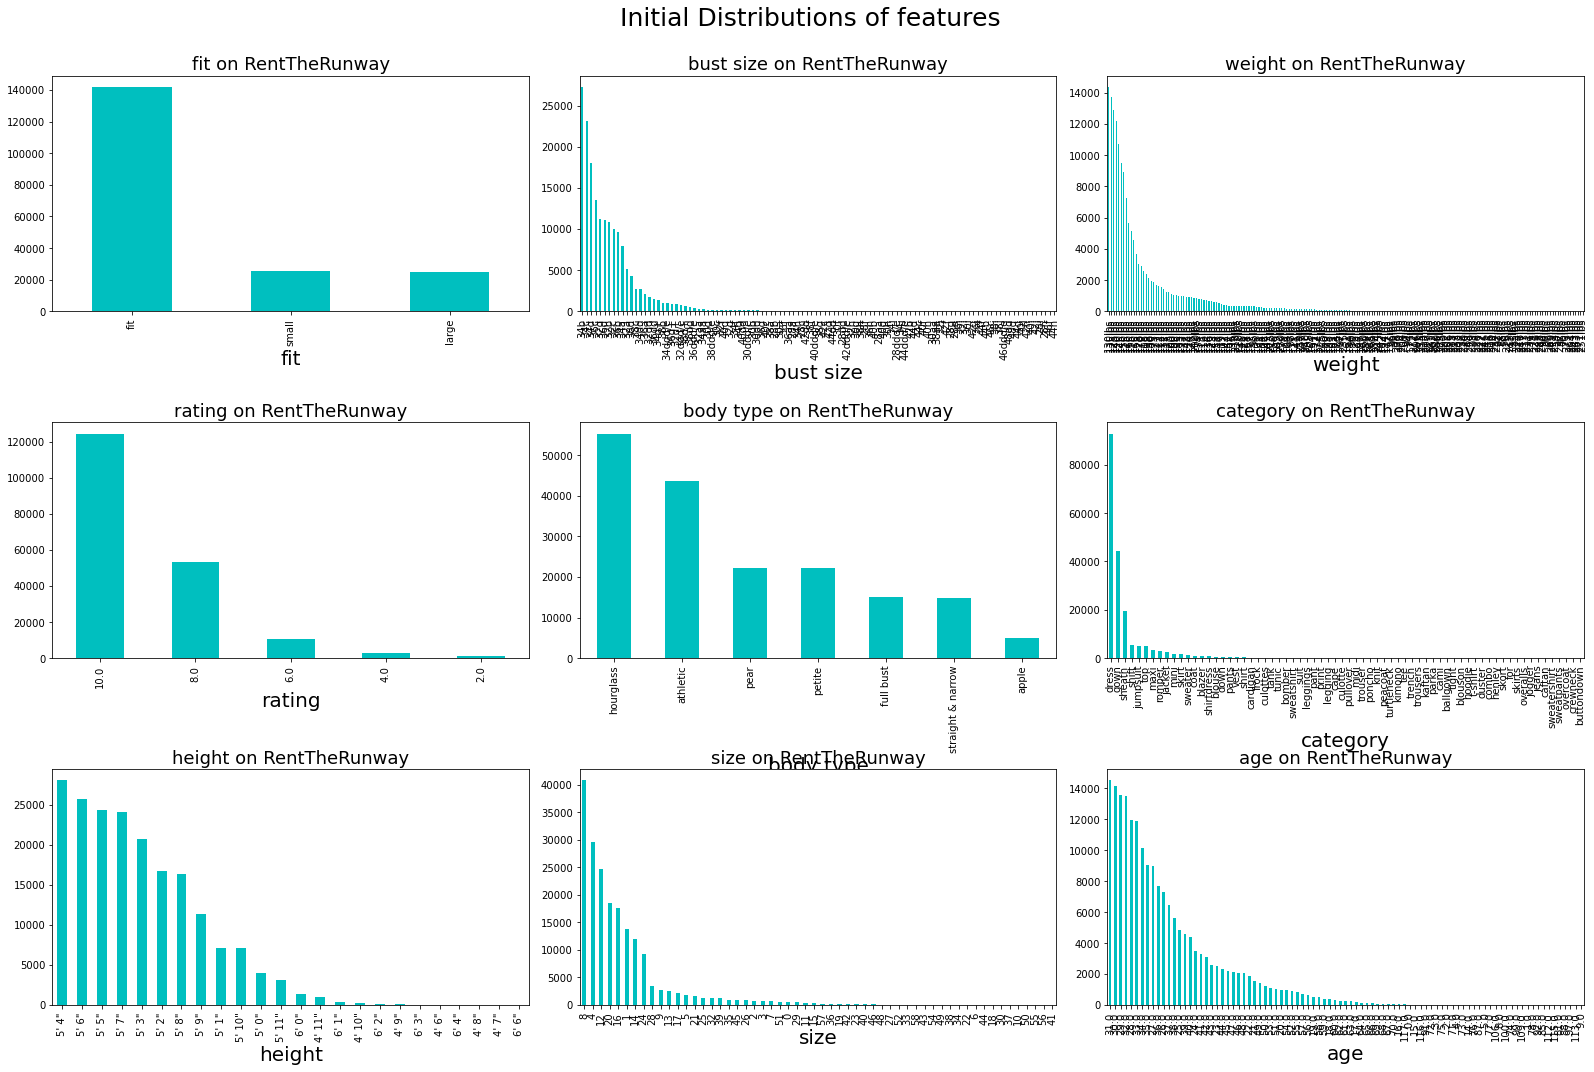

In [9]:
def plot_dist(col, ax):
    df[col][df[col].notnull()].value_counts().plot(kind='bar', facecolor='c', ax=ax)
    ax.set_xlabel('{}'.format(col), fontsize=20)
    ax.set_title("{} on RentTheRunway".format(col), fontsize= 18)
    return ax

f, ax = plt.subplots(3,3, figsize = (22,15))
f.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = ['fit', 'bust size',  'weight',
       'rating',  'body type', 
       'category', 'height', 'size', 'age']
k = 0
for i in range(3):
    for j in range(3):
        plot_dist(cols[k], ax[i][j])
        k += 1
__ = plt.suptitle("Initial Distributions of features", fontsize= 25)

### Step-by-step features processing:
- fit: We'll map these to numerical categories for easier processing as fit_cat

- bust size: We'll parse out the cup size and convert to numerical categories as cup_size_cm.  Given that nearly 10% of the data is missing we'll impute the NA values 

- rating - we'll test applying log to the data since there is a large imbalance and convert to numerical categories as rating_bin

- height: we'll convert to int from feet to cm

- body type: we'll convert these to numerical variables as body_type_cat

- rented for:  convert into numerical bins as occasion

- category: we'll convert these to numerical variables as clothing type

- weight, height, size and age have outliers that need to be addressed





In [10]:
#using a dictionary with map
#map fit to numerical catagories
df['fit_cat'] = df['fit'].map({'small': 0, 'fit': 1, 'large': 2})
#Create a new column with a copy of bust size
df['cup_size'] = df['bust size']
#remove the numerical elements of the bust size to leave only the cup size
df['cup_size'].replace('[0-9]', '', regex= True, inplace= True)
#create a new column for binned ratings and map to low = 0 and high = 1
df['rating_bin'] = df['rating'].map({2: 0, 4: 0, 6: 0, 8: 1, 10: 1})

In [11]:
#Convert height from feet and inches to cm
def height_in_cms(ht):
  if ht.lower() != 'nan':
    ht = ht.replace('\'',' ').replace('\"', '')
    h_ft = int(ht.split()[0])
    if len(ht.split()) > 1:
      h_inch = int(ht.split()[1])
    else:
      h_inch = 0
    h_inch += h_ft * 12
    h_cm = round(h_inch * 2.54, 1)
    return h_cm

df.height = df.height.astype(str).apply(height_in_cms)

In [12]:
df['body_type_cat'] = df['body type'].map({'hourglass': 0, 'straight & narrow': 1,
                                           'pear': 2, 'athletic': 3, 'full bust': 4,'petite':5, 'apple':6})

In [13]:
def convert_cup_size_to_cms(cup_size_code):
  if cup_size_code == 'aa':
    return 10
  if cup_size_code == 'a':
    return 12
  if cup_size_code == 'b':
    return 14
  if cup_size_code == 'c':
    return 16
  if cup_size_code == 'd':
    return 18
  if cup_size_code == 'dd/e':
    return 20
  if cup_size_code == 'ddd/f':
    return 22
  if cup_size_code == 'dddd/g':
    return 24
  if cup_size_code == 'h':
    return 26
  if cup_size_code == 'i':
    return 28
  if cup_size_code == 'j':
    return 30
  if cup_size_code == 'k':
    return 32
  else:
    return str('unknown')

df['cup_size_in_cms'] = df.cup_size.apply(convert_cup_size_to_cms)


In [14]:
#Converting clothing types to numerical bins
# categorized 'rented for' into occasion
# formal= 0, dressy= 1, casual= 2, everyday= 3
df['occasion'] = df['rented for'].map({'formal affair': 0, 'wedding': 0, 'party: cocktail': 0,
                                    'party': 1, 'date': 1,
                                    'vacation': 2, 'other': 2, 
                                    'everyday': 3, 'work': 3,
                                   np.nan: -1})

### Converting clothing types to categorical bins

In [15]:
#using a dictionary to map clothing types to numerical categories. 
# dresses= 0, jumpsuits= 1, pants=2, tops= 3, jackets= 4, misc= 5, skirts= 6
df['clothing_type'] = df['category'].map({'gown': 0, 'dress': 0, 'sheath': 0, 'shirtdress': 0, 'maxi': 0, 'shift': 0,
                                         'frock': 0, 'ballgown':0, 'kaftan': 0, 'caftan': 0, 'kimono': 0,
                                          
                                         'romper': 1, 'jumpsuit': 1, 'overalls': 1, 'suit': 1, 
                                         
                                        'leggings': 2, 'pants': 2, 'culottes': 2, 'trouser': 2, 'pant': 2, 'legging': 2,
                                        'culotte': 2, 'jogger': 2, 'trousers': 2, 'tight': 2, 'sweatpants': 2, 'jeans': 2,
                                         
                                         'top': 3, 'sweater': 3, 'shirt': 3, 'pullover': 3, 'blouse': 3,
                                        'tank': 3, 'tunic': 3, 'sweatershirt': 3, 'tee':3, 'henley': 3, 'cami': 3,
                                         'blouson': 3, 'turtleneck': 3, 't-shirt': 3, 'crewneck': 3, 'buttondown': 3, 
                                        'sweatershirt': 3,
                                         
                                         'jacket': 4, 'coat': 4, 'trench': 4, 'bomber': 4, 'cape': 4, 
                                        'cape': 4, 'blazer': 4, 'vest': 4, 'duster': 4, 'poncho': 4, 'cardigan': 4, 
                                        'peacoat': 4, 'overcoat': 4, 'hoodie': 4, 'parka': 4,
                                         
                                         'down': 5,'knit': 5, 'combo': 5, 'for': 5,
                                         
                                         'skirts': 6, 'skort': 6,  'midi': 6,})
df.clothing_type.value_counts()

0.0    166390
1.0      8383
3.0      7522
4.0      5049
2.0      1092
5.0       527
6.0        71
Name: clothing_type, dtype: int64

In [16]:
clothing_cat_types = df.clothing_type.map({0: 'Dresses', 1: 'Onesies', 2: 'pants', 3: 'Tops', 4: 'Outer wear', 
                                             5: 'Misc', 6: 'skirts', 7: np.nan})

### Remove Outliers Greater than 3 STD

In [17]:
#height outliers greater than 3 standard deviation for each direction
q_low = df["height"].quantile(0.01)
q_hi  = df["height"].quantile(0.99)

df = df[(df["height"] < q_hi) & (df["height"] > q_low)]

df.height.fillna(value=df.height.mean(), inplace=True)
df['height']=df.height.apply (int)

In [18]:
#age outliers
q_low = df["age"].quantile(0.01)
q_hi  = df["age"].quantile(0.99)

df = df[(df["age"] < q_hi) & (df["age"] > q_low)]

df.age.fillna(value=df.age.mean(), inplace=True)
df['age']=df.age.apply (int)

In [19]:
#size outliers
q_low = df["size"].quantile(0.01)
q_hi  = df["size"].quantile(0.99)

df = df[(df["size"] < q_hi) & (df["size"] > q_low)]



In [20]:
#weight outliers
df.weight=df.weight.str.replace('[lbs]','')



In [21]:
# converting weight from string to int
df.weight = pd.to_numeric(df.weight)

In [22]:
# converting weight to 2 standard deviations
q_low = df["weight"].quantile(0.024)
q_hi  = df["weight"].quantile(0.976)

df = df[(df["weight"] < q_hi) & (df["weight"] > q_low)]

df.weight.fillna(value=df.weight.mean(), inplace=True)
df['weight']=df.weight.apply (int)

In [23]:
#removing rows with null review text
df = df[df['review_text'].notna()]

In [24]:
#removing rows with null review text
df = df[df['rating'].notna()]

## Now, let's review the data distributions

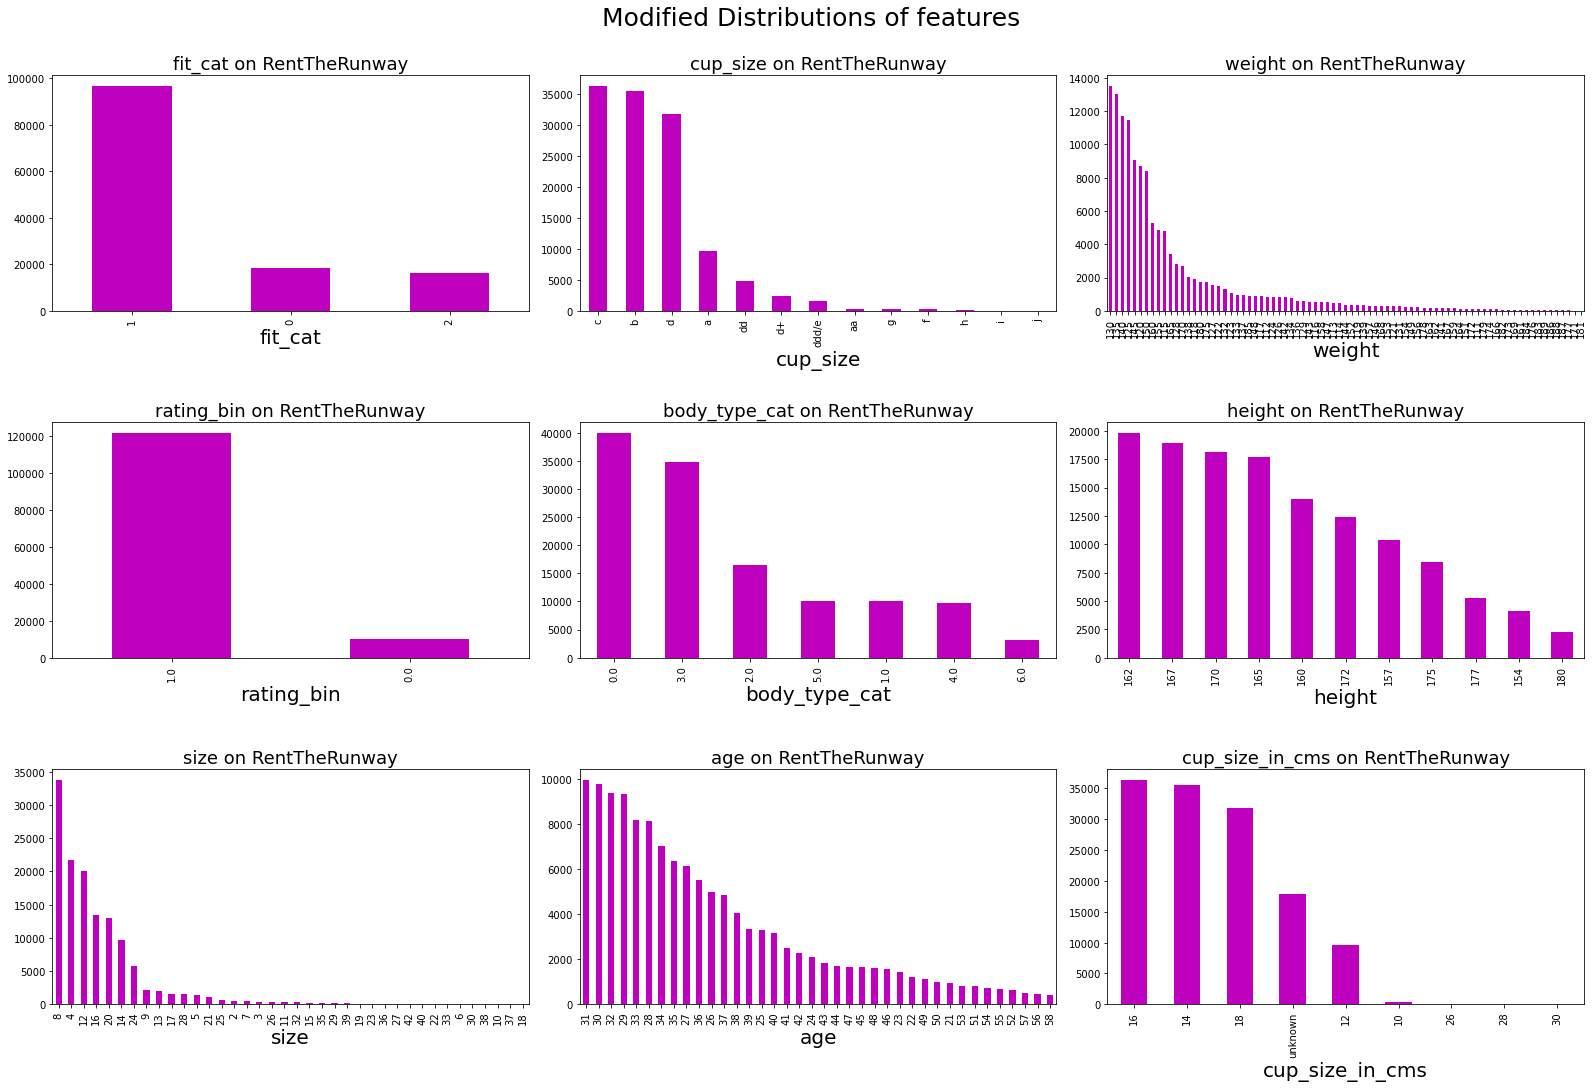

In [25]:
def plot_dist(col, ax):
    df[col][df[col].notnull()].value_counts().plot(kind='bar', facecolor='m', ax=ax)
    ax.set_xlabel('{}'.format(col), fontsize=20)
    ax.set_title("{} on RentTheRunway".format(col), fontsize= 18)
    return ax

f, ax = plt.subplots(3,3, figsize = (22,15))
f.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = ['fit_cat', 'cup_size',  'weight',
       'rating_bin',  'body_type_cat', 
        'height', 'size', 'age', 'cup_size_in_cms']
k = 0
for i in range(3):
    for j in range(3):
        plot_dist(cols[k], ax[i][j])
        k += 1
__ = plt.suptitle("Modified Distributions of features", fontsize= 25)

### Data Observations for "Clean Text"
### Right tail distribution seen on weight, age, height, cup size, and size
### Fit category: most people agreed on the fit of the clothes; a U-shaped distribution is not seen here as expected
### because most people who comment are happy with their rentals
### Ratings: Most people commenting are happy with their rentals and a U-shaped distribution is not seen in this category

## Lets take a look at the data with our new columns

In [26]:
df.head(3)

,Unnamed: 0,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,...,size,age,review_date,fit_cat,cup_size,rating_bin,body_type_cat,cup_size_in_cms,occasion,clothing_type
0,0,fit,420272,34d,2260466,137,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,...,14,28,"April 20, 2016",1,d,1.0,0.0,18,2,1.0
1,1,fit,273551,34b,153475,132,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,...,12,36,"June 18, 2013",1,b,1.0,1.0,14,2,0.0
3,3,fit,909926,34c,126335,135,8.0,formal affair,I rented this for my company's black tie award...,pear,...,8,34,"February 12, 2014",1,c,1.0,2.0,16,0,0.0


## Data Analysis

### Let's review our user buying patterns

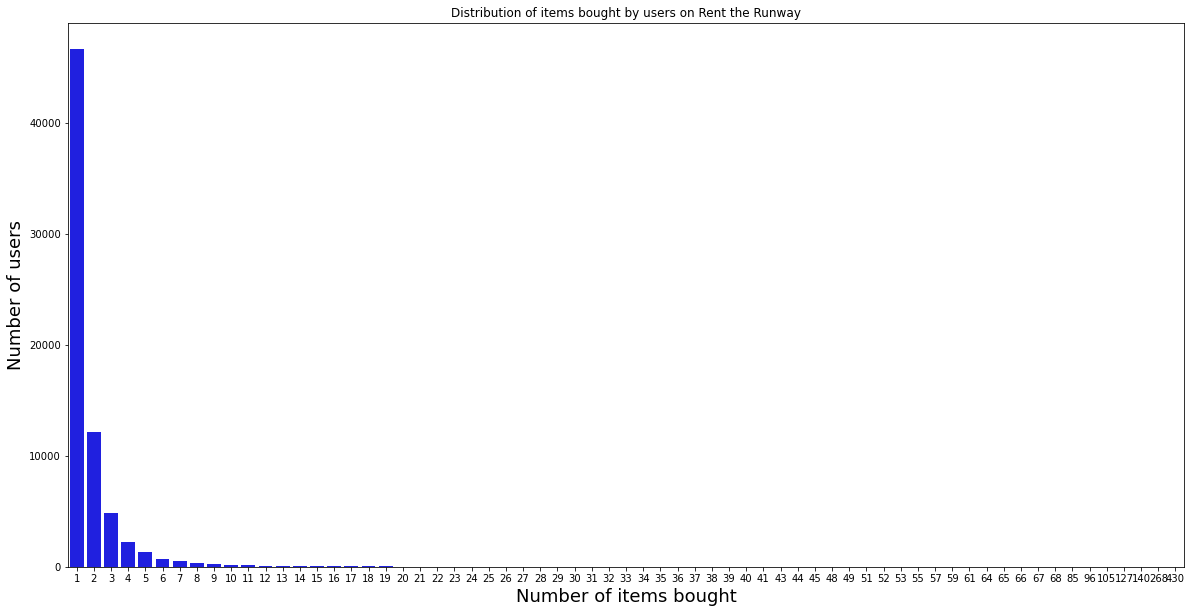

In [27]:
# Users who bought so many items
items_bought = []
total_users = []
for i in range(min(df.user_id.value_counts()), max(df.user_id.value_counts())+1):
    all_users = sum(df.user_id.value_counts() == i)
    if all_users != 0:
        total_users.append(all_users)
        items_bought.append(i)
plt.xlabel("Number of items bought", fontsize = 18)
plt.ylabel("Number of users", fontsize = 18)
plt.title("Distribution of items bought by users on Rent the Runway")
__ = sns.barplot(x=items_bought, y=total_users, color='b')
fig = plt.gcf()
fig.set_size_inches(20,10)

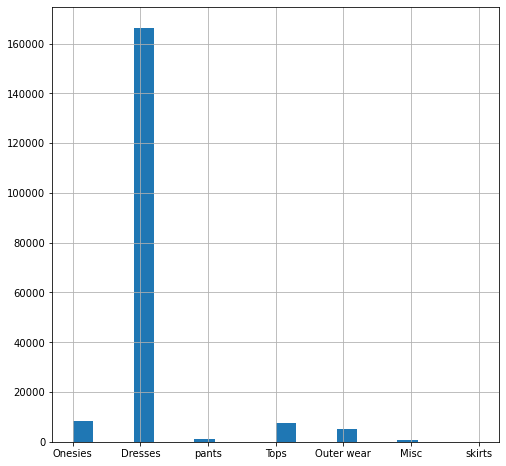

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
clothing_cat_types.hist(bins= 20, figsize= (8, 8))
plt.show()

## Observations:
### Most users only make one purchase and purchase dresses. This is reasonable considering the business model. 
### They are renting clothing for special occasions. 

In [29]:
def countplot(indipendent_features):
  plt.figure(figsize=(100, 50))
  for loc, feature in enumerate(indipendent_features):
    ax = plt.subplot(3, 2, loc+1)
    ax.set_xlabel('{}'.format(feature), fontsize=60)
    chart = sns.countplot(df[feature])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
  return None

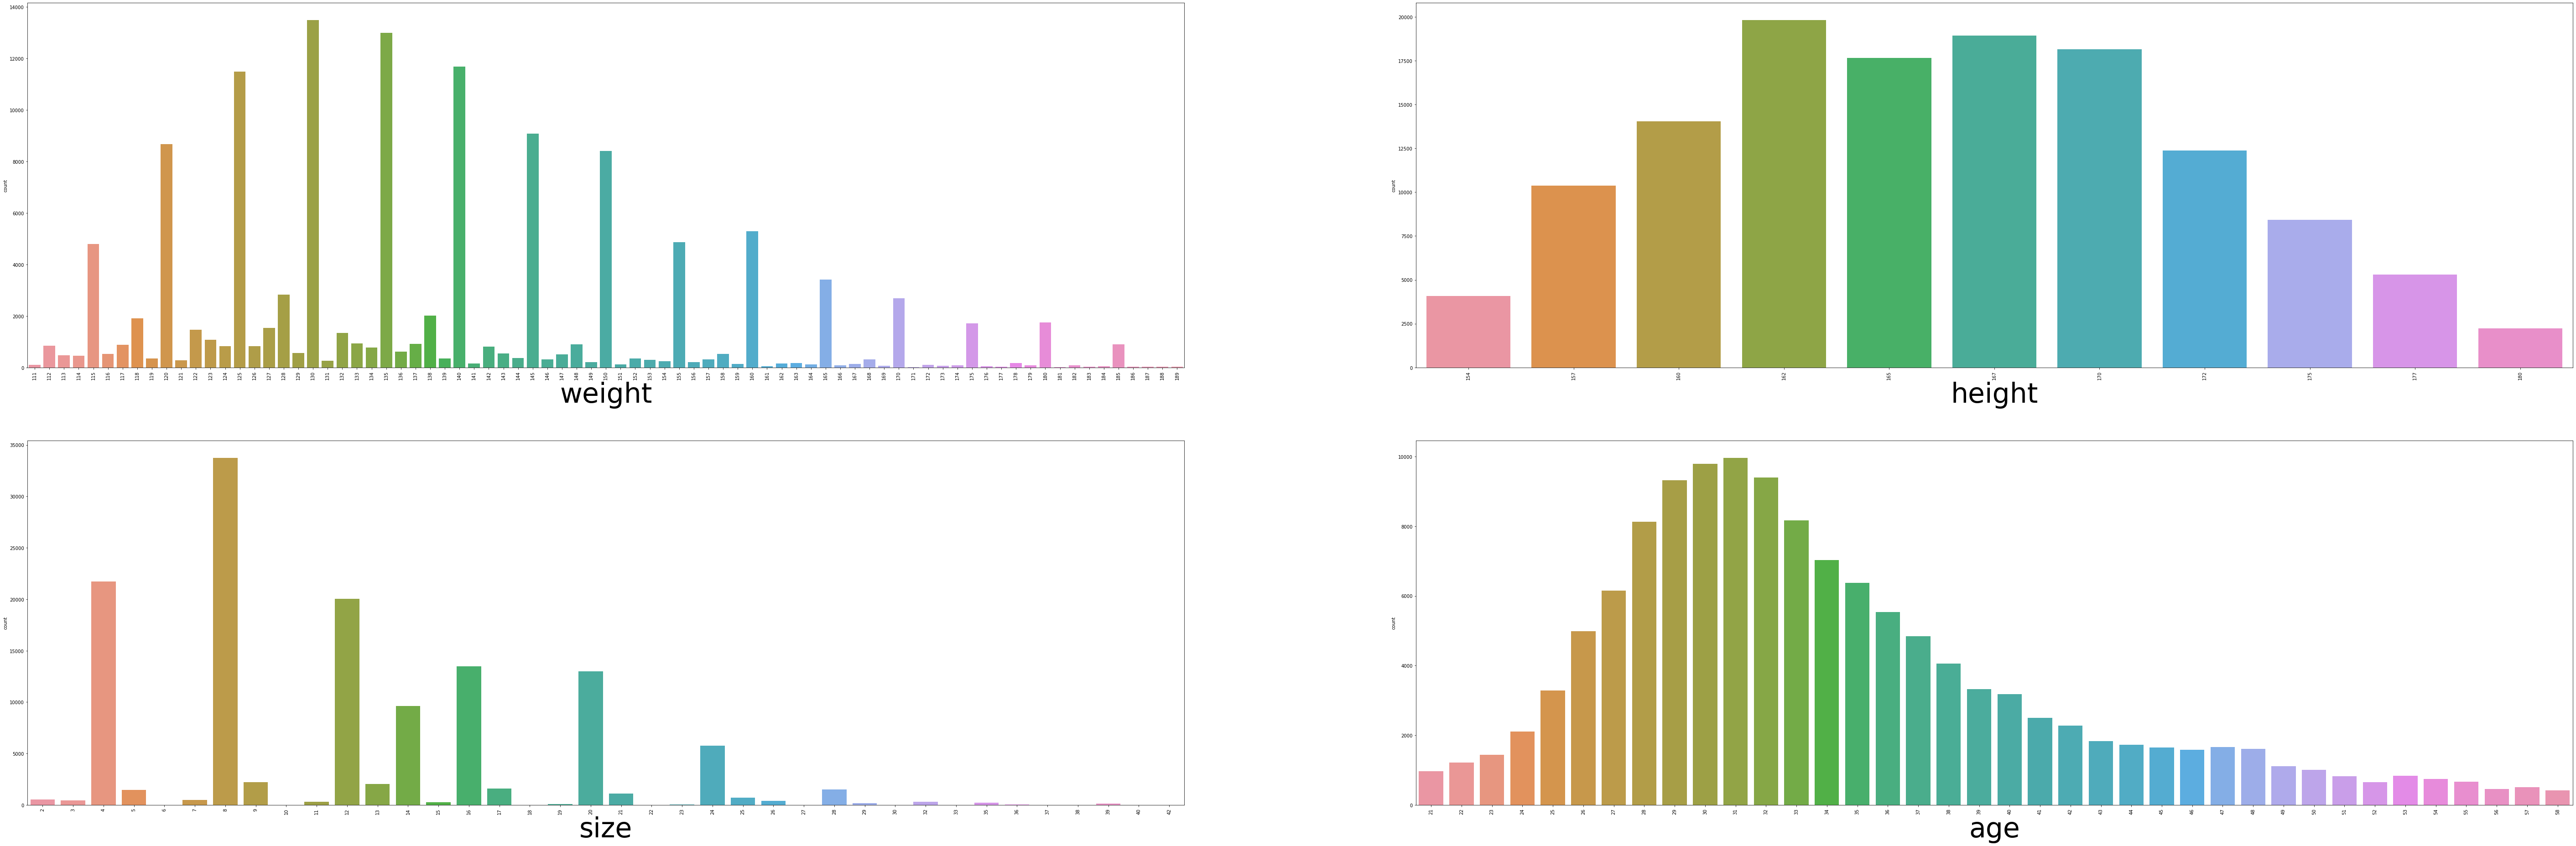

In [30]:
uniques_data = ['weight', 'height', 'size', 'age']
countplot(uniques_data)

In [31]:
#Review data correlatoins
correlations = df.corr()
correlations

,Unnamed: 0,user_id,item_id,weight,rating,height,size,age,fit_cat,rating_bin,body_type_cat,occasion,clothing_type
Unnamed: 0,1.000000,0.000830,-0.004426,0.002725,-0.004806,0.003394,0.001969,-0.000126,0.003412,-0.003241,-0.002900,-0.003027,-0.002344
user_id,0.000830,1.000000,-0.008065,0.003953,-0.009780,-0.008270,0.004211,0.015967,-0.000678,-0.007299,0.005077,-0.006816,-0.014228
item_id,-0.004426,-0.008065,1.000000,-0.038120,-0.008293,0.004507,-0.031518,0.037509,0.006716,-0.021826,0.006540,0.373949,0.593993
weight,0.002725,0.003953,-0.038120,1.000000,-0.024993,0.320476,0.783005,0.039738,-0.004977,-0.011544,-0.139022,-0.036847,-0.032222
rating,-0.004806,-0.009780,-0.008293,-0.024993,1.000000,0.002814,-0.040427,-0.036544,0.042179,0.749969,-0.011489,-0.094913,-0.039118
height,0.003394,-0.008270,0.004507,0.320476,0.002814,1.000000,0.148035,-0.014562,-0.004366,-0.004186,-0.180370,0.000397,0.014752
size,0.001969,0.004211,-0.031518,0.783005,-0.040427,0.148035,1.000000,0.159862,-0.132165,-0.019826,-0.079715,-0.037352,-0.040348
age,-0.000126,0.015967,0.037509,0.039738,-0.036544,-0.014562,0.159862,1.000000,-0.005790,-0.035068,0.015260,0.125543,0.063917
fit_cat,0.003412,-0.000678,0.006716,-0.004977,0.042179,-0.004366,-0.132165,-0.005790,1.000000,0.031311,-0.011037,0.076861,0.065070
rating_bin,-0.003241,-0.007299,-0.021826,-0.011544,0.749969,-0.004186,-0.019826,-0.035068,0.031311,1.000000,-0.004649,-0.087403,-0.045005


In [32]:
# We noticed that weight, age, and height are correlated with size
# sorted from highest to lowest
correlations['size'].sort_values(ascending=False)

size             1.000000
weight           0.783005
age              0.159862
height           0.148035
user_id          0.004211
Unnamed: 0       0.001969
rating_bin      -0.019826
item_id         -0.031518
occasion        -0.037352
clothing_type   -0.040348
rating          -0.040427
body_type_cat   -0.079715
fit_cat         -0.132165
Name: size, dtype: float64

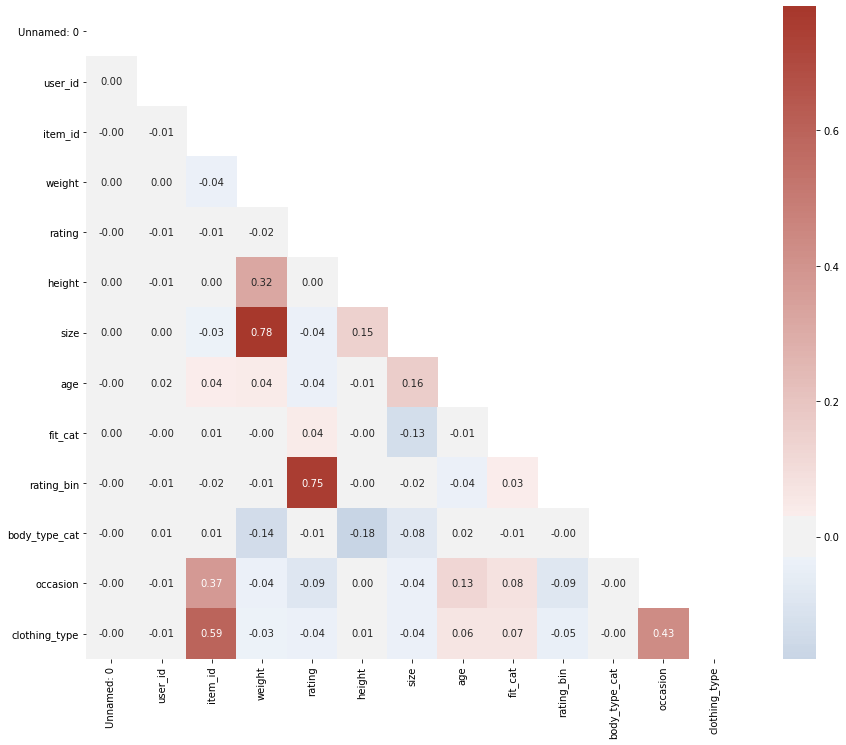

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Calculate pairwise-correlation
matrix = df.corr()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))

sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap)

plt.show();

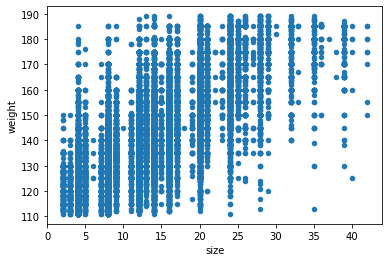

In [34]:
df.plot(kind = "scatter", x = "size", y = "weight")
plt.show()

# wide array of sizes for weight
# normalized view of sizes for weight
# could see a mix of European and American sizing
# Unfortunately cannot consult with our domain expert to verify

# Text Analysis

In [35]:
nlp = spacy.load('en_core_web_lg')
# nltk.corpus stopword list
stopword_list = list(stopwords.words('english'))
# sklearn.feature_extraction.text stopword list
stopword_list = list(ENGLISH_STOP_WORDS)
# specifying part-of-speech tags to use
pos_tags = ['ADJ', 'ADV', 'NOUN', 'VERB']

In [36]:
def preprocess(text):
    # converting text to lowercase
    text = text.lower()
    # Using regex to include only alphabetic characters
    text = re.sub(r'[^a-z]', " ", text)
    # removing stopwords in the string
    doc = nlp(text)
    # using nltk to lemmatize each word in document and keep only the 
    #   adverbs, adjectives, nouns, and verbs that are larger than 2 characters in length
    words = [token.lemma_ for token in doc if token.pos_ in pos_tags and len(token.text) > 2 and \
             token.text not in stopword_list]
    " ".join(w for w in nltk.wordpunct_tokenize(text) \
            if w.lower() in words or not w.isalpha())
    return " ".join(words)

In [37]:
#Create a column called 'Clean Text' that is obtained by preprocessing the 'Review Text' column.
df['Clean Text']=df['review_text'].apply(preprocess)

In [38]:
# viewing and instance of 'Clean Text'
df['Clean Text'][1856]

'thing surprise actually fabric expect structured comfortable fine fit great body bust wayyyy short go really wear bra size make sure shoulder chest hold love dress get lot compliment'

In [39]:
#df[df['Clean Text'].str.contains("wayyy")]

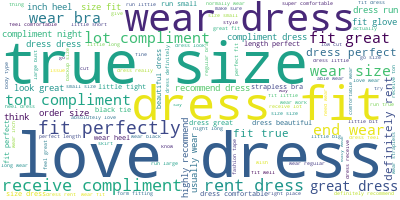

In [40]:
#let us run the wordcloud package to get a visual representation of most common words
# Import the wordcloud library

# Join the different processed titles together.
long_string = ','.join(list(df['Clean Text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='m')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Create Train and Test Data Sets

In [41]:
# creating train/test/split with 'Clean Text' and target variable, 'rating_bin' of 0s and 1s for 'High' and 'Low' ratings
# Remember: imbalanced data set with Ratings of 2, 4, 6 == 0s; 8, 10 == 1s
# Happy customers seemed excited to report their ratings on the website
y=df['rating_bin']
x_train, x_test, y_train, y_test = train_test_split(df['Clean Text'],y, stratify = y,test_size=.20, random_state=11)

In [42]:
#apply the TfidfVectorizer
# Chose Tfidf to get weighted probabilities of words over the CountVectorizer which gives raw word count
v = TfidfVectorizer(max_features= 5000, min_df= 4) 
# performing fit/transform on x_train 
dtm_train = v.fit_transform(x_train)
# performing the tranform on the test set
dtm_test = v.transform(x_test)

In [43]:
# establishing our baseline accuracy.  Want model to perform better than this
df['rating_bin'].value_counts(normalize = True)

1.0    0.924419
0.0    0.075581
Name: rating_bin, dtype: float64

## Naive Bayes Model

In [45]:
#Naive Bayes classifier
nb_classifier = MultinomialNB(alpha=0.01)
# performing the fit on training set
nb_classifier.fit(dtm_train, y_train)
# performing prediction on test set
pred = nb_classifier.predict(dtm_test)
# obtaining prediction score on y_test set
print("Accuracy: ", metrics.accuracy_score(y_test, pred))

Accuracy:  0.9256299002816473


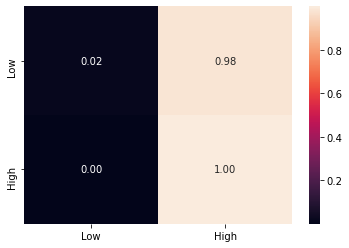

In [46]:
labels = ['Low', 'High']
sns.heatmap(confusion_matrix(y_test, pred, normalize = 'true'), xticklabels = labels, yticklabels = labels,
            annot = True, fmt='.2f')

### Logistic Regresson

In [47]:
#Logistic Regression model
model = LogisticRegression(max_iter = 100000, class_weight = 'balanced') 
# performing fit on training set
model.fit(dtm_train, y_train) 
# applying model to test set
y_pred = model.predict(dtm_test)
print("Accuracy: ", metrics.accuracy_score(y_test, pred))

Accuracy:  0.9256299002816473


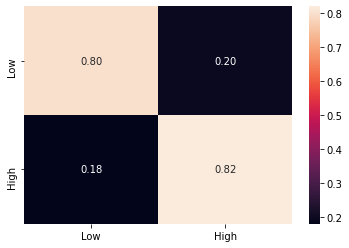

In [48]:
labels = ['Low', 'High']
sns.heatmap(confusion_matrix(y_test, y_pred,normalize = 'true'),xticklabels = labels,
            yticklabels = labels, 
            annot = True, fmt='.2f')

## Train Data with SMOTE

In [49]:
from imblearn.over_sampling import SMOTE
#fit SMOTE
sm = SMOTE(random_state=11)

In [50]:
# resizing the sample to oversize it
x_sm, y_sm = sm.fit_resample(dtm_train, y_train)

In [51]:
#check data balance now
y_sm.value_counts() 

0.0    97152
1.0    97152
Name: rating_bin, dtype: int64

In [52]:
#check data balance now
y_sm.value_counts(normalize= True) 

0.0    0.5
1.0    0.5
Name: rating_bin, dtype: float64

## NB with SMOTE

In [53]:
# acquiring the NB algorithm
nbsmote_classifier = MultinomialNB(alpha=0.01)  
# applying algorithm to oversized sample
nbsmote_classifier.fit(x_sm, y_sm)
pred = nbsmote_classifier.predict(dtm_test)
print("Accuracy: ", metrics.accuracy_score(y_test, pred))

Accuracy:  0.8038745527898302


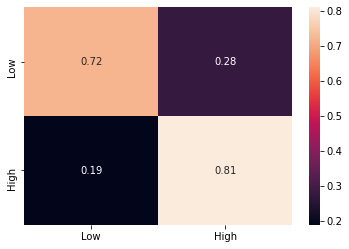

In [54]:
labels = ['Low', 'High']
sns.heatmap(confusion_matrix(y_test, pred,normalize = 'true'), xticklabels = labels, yticklabels = labels,
            annot = True, fmt='.2f')

In [55]:
print("\nClassification Report Naive Bayes with Oversampling: ")
print(classification_report(y_test, pred, target_names=['Low','High']))


Classification Report Naive Bayes with Oversampling: 
              precision    recall  f1-score   support

         Low       0.24      0.72      0.36      1986
        High       0.97      0.81      0.88     24288

    accuracy                           0.80     26274
   macro avg       0.61      0.77      0.62     26274
weighted avg       0.92      0.80      0.84     26274



## LR with SMOTE

In [56]:
logsmote_classifier =  LogisticRegression(max_iter = 100000)  
logsmote_classifier.fit(x_sm, y_sm)
pred = logsmote_classifier.predict(dtm_test)
print("Accuracy: ", metrics.accuracy_score(y_test, pred))

Accuracy:  0.852059069802847


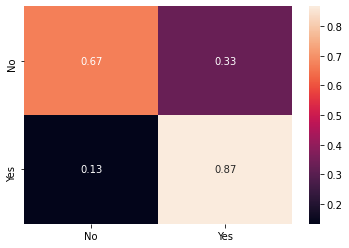

In [57]:
labels = ['No', 'Yes']
sns.heatmap(confusion_matrix(y_test, pred,normalize = 'true'),xticklabels = labels,
            yticklabels = labels,
            annot = True, fmt='.2f')

In [58]:
print("\nClassification Report Logistic Regression with Oversampling: ")
print(classification_report(y_test, pred, target_names=['No', 'Yes']))


Classification Report Logistic Regression with Oversampling: 
              precision    recall  f1-score   support

          No       0.29      0.67      0.41      1986
         Yes       0.97      0.87      0.92     24288

    accuracy                           0.85     26274
   macro avg       0.63      0.77      0.66     26274
weighted avg       0.92      0.85      0.88     26274



## Train Data with NearMiss for Undersampling to correct data imbalance

In [59]:
nr = NearMiss()
x_under, y_under = nr.fit_resample(dtm_train, y_train)

In [60]:
y_under.value_counts()

1.0    7943
0.0    7943
Name: rating_bin, dtype: int64

## NB with NearMiss

In [61]:
nbunder_classifier = MultinomialNB(alpha=0.01)  
nbunder_classifier.fit(x_under, y_under)
pred = nbunder_classifier.predict(dtm_test)
print("Accuracy: ", metrics.accuracy_score(y_test, pred))

Accuracy:  0.2985080307528355


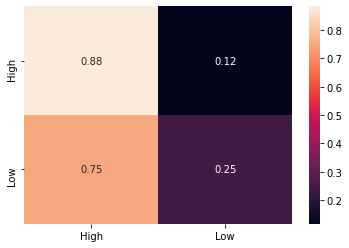

In [62]:
labels = ['High', 'Low']
sns.heatmap(confusion_matrix(y_test, pred,normalize = 'true'),xticklabels = labels,
            yticklabels = labels,
            annot = True, fmt='.2f')

In [63]:
print("\nClassification Report Naive Bayes with Undersampling: ")
print(classification_report(y_test, pred, target_names=['No', 'Yes']))


Classification Report Naive Bayes with Undersampling: 
              precision    recall  f1-score   support

          No       0.09      0.88      0.16      1986
         Yes       0.96      0.25      0.40     24288

    accuracy                           0.30     26274
   macro avg       0.53      0.57      0.28     26274
weighted avg       0.90      0.30      0.38     26274



## LR with NearMiss

In [64]:
logunder =  LogisticRegression(max_iter = 100000)  
logunder.fit(x_under, y_under)
pred = logunder.predict(dtm_test)
print("Accuracy: ", metrics.accuracy_score(y_test, pred))

Accuracy:  0.43963614219380376


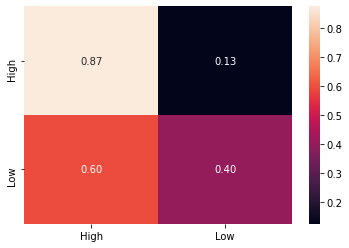

In [65]:
labels = ['High', 'Low']
sns.heatmap(confusion_matrix(y_test, pred,normalize = 'true'),xticklabels = labels,
            yticklabels = labels,
            annot = True, fmt='.2f')

In [66]:
print("\nClassification Report Naive Bayes with Undersampling: ")
print(classification_report(y_test, pred, target_names=['No', 'Yes']))


Classification Report Naive Bayes with Undersampling: 
              precision    recall  f1-score   support

          No       0.11      0.87      0.19      1986
         Yes       0.98      0.40      0.57     24288

    accuracy                           0.44     26274
   macro avg       0.54      0.64      0.38     26274
weighted avg       0.91      0.44      0.54     26274



## Text Explainer using Lime

In [67]:
list(x_test)[11]

'overall good fit hang fabric weight fit little large waist area fabric stretch length perfect easy wear large bust fit just fine dress arrive hole seam good seamstress fix able wear customer service helpful issue stop rent husband thrill rental concept don like wear dress time'

In [68]:
list(y_test)[11]

1.0

In [69]:
#checing the prediction and looking at the words that are contributing to the prediction
y_pred_prob = model.predict_proba(dtm_test)[:, 1]
# creating a pipeline with our Tfidf vectorizer and logistic regression algorithm
c = make_pipeline(v, model)
#Take a string from test instance
mystring = list(x_test)[11] 
# applying pipeline, c, to string instance using parameter pedict_proba() - Prediction probabilities
# "Not Relevant" = 7% and "Relevant" = 93%
print(c.predict_proba([mystring])) 
# created class names
class_names = ["Not Relevant", "Relevant"]
# directing the class names through the limetextexplainer
explainer = LimeTextExplainer(class_names=class_names)
# 
exp = explainer.explain_instance(mystring, c.predict_proba, num_features=10)
                                
exp.as_list()

[[0.3343898 0.6656102]]


[('concept', -0.1703076051609955),
 ('perfect', 0.16615814521775032),
 ('easy', 0.12949290835110847),
 ('helpful', 0.12141432578511364),
 ('stop', 0.11925566409937788),
 ('large', -0.0856588499221242),
 ('weight', 0.08183352482857244),
 ('hole', -0.08014355889119748),
 ('fabric', -0.06345173890709807),
 ('service', -0.05967175746437331)]

In [70]:
# taking exp and demonstrating
exp.show_in_notebook()

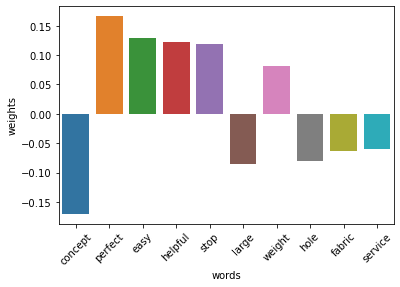

In [71]:
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
weights = OrderedDict(exp.as_list())
lime_weights = pd.DataFrame({"words": list(weights.keys()), "weights": list(weights.values())})

sns.barplot(x = "words", y = "weights", data = lime_weights)
plt.xticks(rotation = 45)
#plt.title("Sample features weights given by LIME")
plt.show()

## Topic Modeling

In [79]:
#read in the excel file and review the data in the df
summary= df['Clean Text']
summary.head()


0    adorable romper belt zipper little hard naviga...
1    rent dress photo shoot theme hollywood glam bi...
3    rent company black tie award banquet like dres...
4    petite upper body extremely athletic typically...
5    actually wear fit perfectly fabric little thic...
Name: Clean Text, dtype: object

In [80]:
#apply the TfidfVectorizer
# Chose Tfidf to get weighted probabilities of words over the CountVectorizer which gives raw word count
v = TfidfVectorizer(max_features= 5000, min_df= 4) 
# performing fit/transform on x_train 
dtm = v.fit_transform(summary)

In [81]:
#function to get topics and put them in dataframe columns - we pass an empty dataframe to it
#def get_topics(model, cv, model_name, df, top_n = 20):
def get_topics(lsi_model, v, df, top_n= 10):
        
        # creating for loop to iterate through topics and words to create list
        for index, topic in enumerate(lsi_model.components_):
            #print("Topic %d:" % (idx))
            # creating topic label
            topic_label = "Topic_" + str(index + 1)
            # putting list of words in Series
            df[topic_label] = [(v.get_feature_names()[i]) for i in topic.argsort()[:-top_n-1:-1]]

In [82]:
# Creating dataframe to put topic to words in
lsi_df = pd.DataFrame()

# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=10, n_iter = 5000)
lsi_Z = lsi_model.fit_transform(dtm)

# calling get_topics function
get_topics(lsi_model, v, lsi_df)

# calling lsi dataframe in topic to word format
lsi_df.T

,0,1,2,3,4,5,6,7,8,9
Topic_1,dress,wear,fit,size,great,love,perfect,little,comfortable,compliment
Topic_2,size,true,fit,run,small,large,order,big,bust,usually
Topic_3,fit,great,perfect,comfortable,true,perfectly,love,flattering,color,compliment
Topic_4,great,little,tight,look,short,small,bit,fit,large,waist
Topic_5,perfect,heel,long,length,inch,wear,fit,short,regular,bra
Topic_6,love,perfect,dress,flattering,color,rent,fit,fabric,pocket,material
Topic_7,little,fit,compliment,perfect,small,tight,get,love,perfectly,big
Topic_8,dress,great,beautiful,order,rent,rtr,wedding,color,look,event
Topic_9,love,long,short,great,true,heel,little,length,size,compliment
Topic_10,wear,love,small,great,run,perfect,bra,large,work,usually
